In [1]:
import os
import glob
import tensorflow as tf
import wave
import concurrent.futures
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
import random


2025-04-10 14:10:29.086781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 14:10:29.094529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744290629.102602    9964 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744290629.104951    9964 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 14:10:29.113273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# ---------------------------------------------------------
# 1. Define dataset directories and assign dataset IDs
# ---------------------------------------------------------
australia_dir = '/mnt/f/mars_global_acoustic_study/australia_acoustics/'
indonesia_dir = '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/'
maldives_dir  = '/mnt/f/mars_global_acoustic_study/maldives_acoustics/'
mexico_dir    = '/mnt/f/mars_global_acoustic_study/mexico_acoustics/'

# Dataset IDs: Australia = 1, Indonesia = 2, Maldives = 3, Mexico = 4

In [3]:
skip = "yes"

In [4]:
# ---------------------------------------------------------
# 2. Control variable for balancing:
#    Total samples per dataset (50/50 split for H and D).
# ---------------------------------------------------------
samples_per_class = 5000  # e.g., 500 H and 500 D per dataset

In [5]:
# ---------------------------------------------------------
# 3. Helper: Check if a WAV file is exactly 60 seconds long.
# ---------------------------------------------------------
def is_sixty_seconds_file(path):
    try:
        with wave.open(path, 'rb') as wf:
            frames = wf.getnframes()
            sr = wf.getframerate()
            return frames == sr * 60
    except Exception:
        return False

In [6]:
# ---------------------------------------------------------
# 4. Label extraction functions (Python version)
# ---------------------------------------------------------
import os

def extract_label_from_folder_py(file_path):
    # For datasets with subfolders.
    # Example file path: .../Degraded_Moth32/20230207_050000.WAV
    # We split on os.sep and take the parent folder (e.g. "Degraded_Moth32")
    parts = file_path.split(os.sep)
    if len(parts) < 2:
        return -1
    folder = parts[-2]
    # Use the first character of the folder name.
    if folder.startswith("H"):
        return 0
    elif folder.startswith("D"):
        return 1
    else:
        return -1

def extract_label_from_filename_py(file_path):
    # For Indonesia files.
    # Example file path: '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/ind_D1_20220829_120000.WAV'
    # Remove the prefix if it exists.
    prefix = '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/'
    if file_path.startswith(prefix):
        file_path = file_path[len(prefix):]
    # Now file_path might look like "ind_D1_20220829_120000.WAV"
    parts = file_path.split('_')
    if len(parts) < 2:
        return -1
    # Take the first character of the second token, e.g., "D1" -> "D"
    if parts[1][0] == "H":
        return 0
    elif parts[1][0] == "D":
        return 1
    else:
        return -1

In [7]:
example_path = '/mnt/f/mars_global_acoustic_study/mexico_acoustics/H_M43/20230531_212400.WAV'
print(extract_label_from_folder_py(example_path))

0


In [8]:
# Example usage:
example_path = '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/ind_D1_20220829_120000.WAV'
print(extract_label_from_filename_py(example_path))  # Expected output: 1

1


In [9]:
# ---------------------------------------------------------
# 5. Build a single file list for all datasets.
# ---------------------------------------------------------
import glob
import concurrent.futures
import random

def check_file(f, ds_id):
    if is_sixty_seconds_file(f):
        return f  # Return the file path if valid.
    return None

def get_files_for_dataset(root_dir, ds_id, samples_per_class=50):
    pos_files = []
    neg_files = []
    # Build the glob pattern (assumes a subfolder structure).
    if ds_id == 2:
        pattern = os.path.join(root_dir, "*.WAV")
    else:
        pattern = os.path.join(root_dir, "*", "*.WAV")
    files = glob.glob(pattern)
    print(f"Dataset {ds_id}: Total files found by glob: {len(files)}")
    # Shuffle the file list for random processing.
    random.shuffle(files)
    
    # Loop over the files until we have enough for both classes.
    for f in files:
        # Stop if we've collected enough files for both classes.
        if len(pos_files) >= samples_per_class and len(neg_files) >= samples_per_class:
            break
        
        # Check if the file is exactly 60 seconds long.
        if not is_sixty_seconds_file(f):
            continue
        
        # Extract the label depending on the dataset.
        if ds_id == 2:
            label = extract_label_from_filename_py(f)
        else:
            label = extract_label_from_folder_py(f)
        
        # Only add files with a valid label.
        if label == 1 and len(pos_files) < samples_per_class:
            pos_files.append((f, label, float(ds_id)))
        elif label == 0 and len(neg_files) < samples_per_class:
            neg_files.append((f, label, float(ds_id)))
    
    files_found = pos_files + neg_files
    random.shuffle(files_found)
    print(f"Dataset {ds_id}: Collected {len(files_found)} files (target was {2 * samples_per_class}).")
    return files_found

In [10]:
files_australia = get_files_for_dataset(australia_dir, ds_id=1, samples_per_class=samples_per_class)

Dataset 1: Total files found by glob: 97232


KeyboardInterrupt: 

In [ ]:
files_maldives  = get_files_for_dataset(maldives_dir,  ds_id=3, samples_per_class=samples_per_class)

Dataset 3: Total files found by glob: 58525
Dataset 3: Collected 32000 files (target was 32000).


In [ ]:
files_mexico    = get_files_for_dataset(mexico_dir,    ds_id=4, samples_per_class=samples_per_class)

Dataset 4: Total files found by glob: 86383
Dataset 4: Collected 32000 files (target was 32000).


In [ ]:
files_indonesia = get_files_for_dataset(indonesia_dir, ds_id=2, samples_per_class=samples_per_class)

Dataset 2: Total files found by glob: 267776
Dataset 2: Collected 32000 files (target was 32000).


In [ ]:
# Combine file lists.
all_files = files_australia + files_indonesia + files_maldives + files_mexico
print(f"Total valid files: {len(all_files)}")

Total valid files: 128000


In [ ]:
print("Sample files:")
for i, item in enumerate(all_files[:5]):
    print(item)

Sample files:
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Healthy_Moth35/20230215_141600.WAV', 0, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Degraded_Moth32/20230227_002400.WAV', 1, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Healthy_Moth37/20230316_055200.WAV', 0, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Degraded_Moth34/20230304_203200.WAV', 1, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Degraded_Moth32/20230219_083600.WAV', 1, 1.0)


In [ ]:
# all_files is a list of tuples (file_path, ds_value)
pos_files = [item for item in all_files if item[1] == 1]
neg_files = [item for item in all_files if item[1] == 0]
x = [item for item in all_files if item[1] == -1]
print("Positive files count:", len(pos_files))
print("Negative files count:", len(neg_files))


Positive files count: 64000
Negative files count: 64000


In [ ]:
# ---------------------------------------------------------
# 6. Create a tf.data.Dataset from the file list and extract labels.
# ---------------------------------------------------------
# Now, all_files is a list of tuples: (file_path, label, dataset_id)
file_paths = [f for f, label, ds in all_files]
labels = [label for f, label, ds in all_files]
ds_ids = [ds for f, label, ds in all_files]

# Create the dataset from a tuple of file_paths, ds_ids, and labels.
ds_all = tf.data.Dataset.from_tensor_slices((file_paths, ds_ids, labels))

def restructure(file_path, dataset_id, label):
    # Return a tuple in the format: ((file_path, dataset_id), label)
    return ((file_path, tf.cast(dataset_id, tf.float32)), label)

ds_all = ds_all.map(restructure, num_parallel_calls=tf.data.AUTOTUNE)

I0000 00:00:1744222926.440502    1801 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
ds_all

<_ParallelMapDataset element_spec=((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
if skip != "yes":    
    print("First sample (per label) from each dataset:")

    for ds_id in [1, 2, 3, 4]:
        for label_val in [0, 1]:
            # Filter ds_all for the current dataset ID and label.
            ds_filtered = ds_all.filter(lambda inputs, lbl: tf.logical_and(
                tf.equal(inputs[1], tf.cast(ds_id, tf.float32)),
                tf.equal(lbl, label_val)
            ))
            # Take the first element.
            sample = next(iter(ds_filtered.take(1)), None)
            if sample is None:
                print(f"Dataset {ds_id} | Label: {label_val} | No sample found.")
            else:
                ((file_path, dataset_id), lbl) = sample
                # Decode file_path if it is in bytes.
                file_path_str = file_path.numpy().decode('utf-8') if isinstance(file_path.numpy(), bytes) else file_path.numpy()
                print(f"Dataset {int(dataset_id.numpy())} | Label: {lbl.numpy()} | Filename: {file_path_str}")


In [ ]:
if skip != "yes":
    def count_by_ds(ds, ds_id):
        ds_filtered = ds.filter(lambda inputs, label: tf.equal(inputs[1], tf.cast(ds_id, tf.float32)))
        count0 = ds_filtered.filter(lambda inputs, label: tf.equal(label, 0)).reduce(0, lambda x, _: x+1)
        count1 = ds_filtered.filter(lambda inputs, label: tf.equal(label, 1)).reduce(0, lambda x, _: x+1)
        return count0.numpy(), count1.numpy()

    for ds_id in [1, 2, 3, 4]:
        c0, c1 = count_by_ds(ds_all, ds_id)
        print(f"Dataset {ds_id} - Healthy (0): {c0}, Degraded (1): {c1}")

In [ ]:
# ---------------------------------------------------------
# 7. Balance the dataset per location.
#    We first split by dataset ID, then select samples_per_class per label.
# ---------------------------------------------------------
def filter_by_ds(ds, ds_id):
    # The second element of inputs (index 1) is the dataset ID.
    return ds.filter(lambda inputs, label: tf.equal(inputs[1], tf.cast(ds_id, tf.float32)))

def balance_ds(ds):
    # Use samples_per_class directly for each label.
    samples_per_label = samples_per_class  
    balanced = None
    for label_val in [0, 1]:
        ds_label = ds.filter(lambda inputs, label: tf.equal(label, label_val))
        ds_label = ds_label.shuffle(10000).take(samples_per_label)
        if balanced is None:
            balanced = ds_label
        else:
            balanced = balanced.concatenate(ds_label)
    return balanced.shuffle(10000)

balanced_datasets = []
for ds_id in [1, 2, 3, 4]:
    ds_filtered = filter_by_ds(ds_all, ds_id)
    balanced_subset = balance_ds(ds_filtered)
    balanced_datasets.append(balanced_subset)  # Append the balanced subset

# Concatenate all balanced datasets into one.
balanced_data = balanced_datasets[0]
for ds in balanced_datasets[1:]:
    balanced_data = balanced_data.concatenate(ds)

In [ ]:
if skip != "yes":    
    def count_labels_batched(ds):
        total_healthy = 0
        total_degraded = 0
        for (_, labels) in ds:
            # labels is a tensor of shape (batch_size,)
            total_healthy += tf.reduce_sum(tf.cast(tf.equal(labels, 0), tf.int32)).numpy()
            total_degraded += tf.reduce_sum(tf.cast(tf.equal(labels, 1), tf.int32)).numpy()
        return total_healthy, total_degraded

    count0, count1 = count_labels_batched(balanced_data)
    print(f"Balanced dataset counts - Healthy (0): {count0}, Degraded (1): {count1}")


In [ ]:
if skip != "yes":    
    def count_by_label(ds, label_val):
        # This function filters the dataset for a given label and counts the elements.
        return ds.filter(lambda inputs, label: tf.equal(label, label_val)) \
                .reduce(0, lambda x, _: x + 1).numpy()

    print("Counts for each dataset in the balanced data:")
    for ds_id, ds in zip([1, 2, 3, 4], balanced_datasets):
        count_healthy = count_by_label(ds, 0)
        count_degraded = count_by_label(ds, 1)
        print(f"Dataset {ds_id} - Healthy (0): {count_healthy}, Degraded (1): {count_degraded}")

In [ ]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    target_sr = 16000
    orig_length = tf.shape(wav)[0]
    new_length = tf.cast(tf.cast(orig_length, tf.float32) *
                         (tf.cast(target_sr, tf.float32) / tf.cast(sample_rate, tf.float32)),
                         tf.int32)
    
    # Resize the audio by treating it as a 1-row image.
    wav_expanded = tf.expand_dims(tf.expand_dims(tf.expand_dims(wav, 0), 0), -1)
    wav_resized = tf.image.resize(wav_expanded, size=[1, new_length], method='bilinear')
    wav_resized = tf.squeeze(wav_resized, axis=[0, 1, 3])
    return wav_resized

def preprocess_mel(inputs, label):
    """
    inputs: a tuple (file_path, dataset_id)
    label: class label
    Returns: ((mel_spectrogram, extra_features), label)
    """
    file_path, dataset_id = inputs
    dataset_id = tf.cast(dataset_id, tf.float32)
    
    # 1. Load the waveform and pad to 48000 samples.
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    padding_amount = tf.maximum(48000 - tf.shape(wav)[0], 0)
    wav = tf.concat([tf.zeros([padding_amount], dtype=tf.float32), wav], axis=0)
    
    # 2. Compute the STFT.
    stfts = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(stfts)  # shape: (1491, 257)
    
    # 3. Convert the linear spectrogram to the mel scale.
    num_spectrogram_bins = tf.shape(spectrogram)[-1]  # expected: 257
    num_mel_bins = 64
    sample_rate = 16000
    lower_edge_hertz = 80.0
    upper_edge_hertz = 7600.0
    mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate,
        lower_edge_hertz, upper_edge_hertz)
    mel_spectrogram = tf.tensordot(spectrogram, mel_weight_matrix, 1)
    mel_spectrogram.set_shape([1491, num_mel_bins])
    
    # 4. Log scaling.
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)  # shape: (1491, 64, 1)
    
    # 5. Compute extra features (same as your linear pipeline).
    filename = tf.strings.split(file_path, os.sep)[-1]
    is_indonesia = tf.strings.regex_full_match(filename, r'^ind.*')
    
    def extract_time():
        parts = tf.strings.split(filename, '_')
        time_str = tf.strings.substr(parts[1], 0, 4)
        time_num = tf.strings.to_number(time_str, out_type=tf.float32)
        return time_num / 2359.0  # normalization example
    
    time_feature = tf.cond(is_indonesia,
                           lambda: tf.constant(0.0, dtype=tf.float32),
                           extract_time)
    dataset_feature = dataset_id / 4.0
    extra_features = tf.stack([time_feature, dataset_feature])  # shape: (2,)
    
    # 6. Return in the same structure as your linear pipeline.
    return (mel_spectrogram, extra_features), label


In [ ]:
filepath, label = balanced_data.shuffle(buffer_size=10).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess_mel(filepath, label)

In [ ]:
spectrogram[0][0]

<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[-5.3722043],
       [-5.6905866],
       [-5.7998066],
       [-5.8571963],
       [-6.225125 ],
       [-6.50137  ],
       [-5.3340845],
       [-4.292539 ],
       [-4.178761 ],
       [-4.537927 ],
       [-4.741101 ],
       [-4.4374204],
       [-4.071913 ],
       [-4.333677 ],
       [-4.395058 ],
       [-4.5263553],
       [-4.713995 ],
       [-4.9934344],
       [-5.939558 ],
       [-5.260118 ],
       [-4.969609 ],
       [-5.479545 ],
       [-5.326516 ],
       [-5.5542016],
       [-5.1473875],
       [-4.925954 ],
       [-5.182395 ],
       [-5.139736 ],
       [-4.863642 ],
       [-4.614539 ],
       [-4.1941385],
       [-3.9714763],
       [-3.611967 ],
       [-3.3031938],
       [-3.403804 ],
       [-3.9405925],
       [-3.435434 ],
       [-2.9154499],
       [-3.2542326],
       [-3.8102202],
       [-3.9437082],
       [-3.430875 ],
       [-3.3929846],
       [-3.1171207],
       [-3.097954 ],
      

In [ ]:
batch_size = 16
balanced_data = balanced_data.map(preprocess_mel, num_parallel_calls=tf.data.AUTOTUNE)
balanced_data = balanced_data.shuffle(buffer_size=10000)
balanced_data = balanced_data.batch(batch_size)

In [ ]:
# Now take the fixed subset, cache it, and repeat it
balanced_data = balanced_data.take(10000).cache().repeat()
balanced_data = balanced_data.prefetch(tf.data.AUTOTUNE)

# Split into training and testing datasets
train = balanced_data.take(6400)
test = balanced_data.skip(6400).take(1600)

In [ ]:
for batch in balanced_data.take(1):
    spectrograms, labels = batch
    print("Spectrograms shape:", spectrograms[0].shape)
    print("Labels shape:", labels.shape)

Spectrograms shape: (16, 1491, 64, 1)
Labels shape: (16,)


2025-04-09 19:22:21.459354: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-09 19:22:21.485152: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
print("Batches:", batch_size)
print("Batches for training", ((samples_per_class*8)/batch_size)*0.8)
print("Batches for testing", ((samples_per_class*8)/batch_size)*0.2)

Batches: 16
Batches for training 6400.0
Batches for testing 1600.0


In [ ]:
train = balanced_data.take(6400)
test = balanced_data.skip(6400).take(1600)

In [ ]:
samples, labels = train.as_numpy_iterator().next()

2025-04-09 19:22:29.285533: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
samples[0].shape

(16, 1491, 64, 1)

In [ ]:
samples[1].shape

(16, 2)

In [ ]:
# ---------------------------------------------------------
# 10. Build a multi-input model (spectrogram + extra features)
# ---------------------------------------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, concatenate


# Spectrogram input
spect_input = Input(shape=(1491, 64, 1), name='spectrogram')

# Block 1: 7x7 kernel for large receptive field
x = Conv2D(32, (7, 7), padding='same')(spect_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Block 2: 3x3 kernel
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Block 3: 3x3 kernel with increased filters
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

# Global pooling to collapse sptial dimensions
x = GlobalAveragePooling2D()(x)

# Extra features branch (if you have 2 extra normalized features)
extra_input = Input(shape=(2,), name='extra_features')
y = Dense(16, activation='relu')(extra_input)

# Combine the convolutional features with extra features
combined = concatenate([x, y])
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.6)(combined)
output = Dense(1, activation='sigmoid')(combined)

# Use AdamW with weight decay for improved regularization
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.00003,
    weight_decay=0.0000015
)

model = Model(inputs=[spect_input, extra_input], outputs=output)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram         │ (None, 1491, 64,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1491, 64,  │      1,600 │ spectrogram[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1491, 64,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1491, 64,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 745, 32,   │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 745, 32,   │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 745, 32,   │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 745, 32,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 745, 32,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 372, 16,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 372, 16,   │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 372, 16,   │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 372, 16,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 372, 16,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 186, 8,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 186, 8,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_features      │ (None, 2)         │          0 │ -               

 Total params: 62,961 (245.94 KB)

 Trainable params: 62,641 (244.69 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
# ---------------------------------------------------------
# 11. Train the model
# ---------------------------------------------------------
hist = model.fit(train, epochs=12, validation_data=test)

Epoch 1/12


/home/os/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['spectrogram', 'extra_features']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2025-04-09 19:22:40.673103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:44: Filling up shuffle buffer (this may take a while): 839 of 1000
2025-04-09 19:22:41.174704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1744222961.217396    9491 service.cc:148] XLA service 0x7f65f0017250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744222961.217861    9491 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-09 19:22:41.272427: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIR

   6/6400 ━━━━━━━━━━━━━━━━━━━━ 2:57 28ms/step - accuracy: 0.3835 - loss: 0.9758 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1744222964.392855    9491 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6400/6400 ━━━━━━━━━━━━━━━━━━━━ 201s 29ms/step - accuracy: 0.8289 - loss: 0.3902 - precision: 0.5739 - recall: 0.4411 - val_accuracy: 0.4697 - val_loss: 0.6995 - val_precision: 0.3562 - val_recall: 0.9997
Epoch 2/12
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 141s 22ms/step - accuracy: 0.9458 - loss: 0.1628 - precision: 0.8534 - recall: 0.7421 - val_accuracy: 0.9532 - val_loss: 0.2837 - val_precision: 0.8688 - val_recall: 0.9900
Epoch 3/12
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 136s 21ms/step - accuracy: 0.9649 - loss: 0.1091 - precision: 0.8756 - recall: 0.8252 - val_accuracy: 0.6661 - val_loss: 0.5454 - val_precision: 0.4676 - val_recall: 0.9975
Epoch 4/12
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 130s 20ms/step - accuracy: 0.9741 - loss: 0.0842 - precision: 0.8891 - recall: 0.8645 - val_accuracy: 0.4996 - val_loss: 0.8487 - val_precision: 0.3696 - val_recall: 0.9995
Epoch 5/12
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 134s 21ms/step - accuracy: 0.9784 - loss: 0.0710 - precision: 0.9042 - recall: 0.8893 - val_accuracy: 0.4828 

KeyboardInterrupt: 

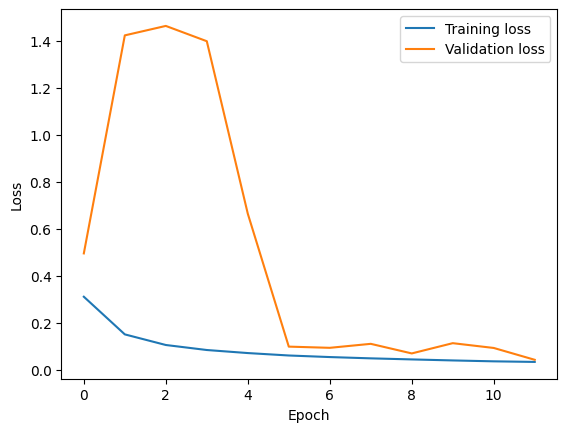

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

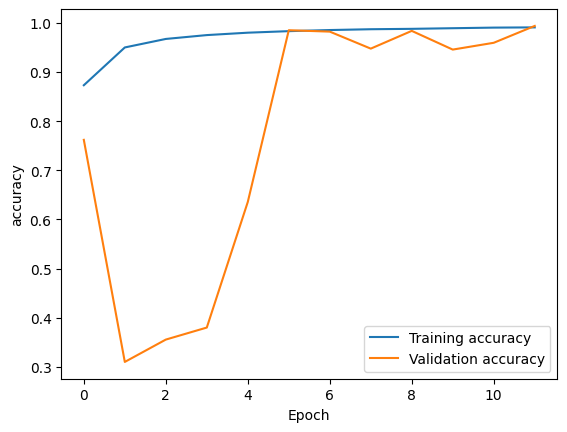

In [ ]:
plt.plot(hist.history['accuracy'], label='Training accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

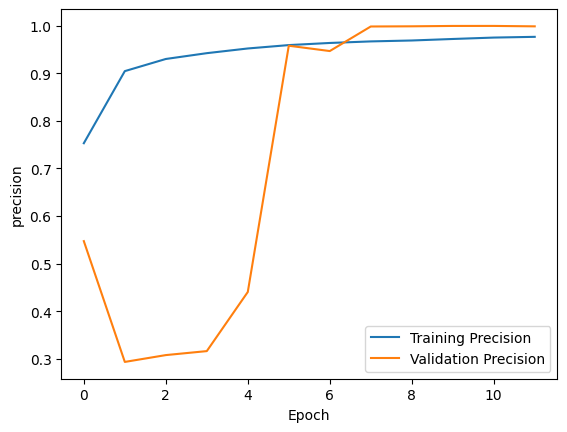

In [ ]:
plt.plot(hist.history['precision'], label='Training Precision')
plt.plot(hist.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()
plt.show()

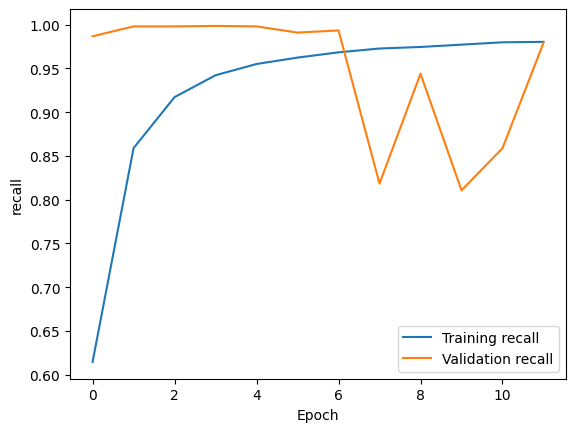

In [ ]:
plt.plot(hist.history['recall'], label='Training recall')
plt.plot(hist.history['val_recall'], label='Validation recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend()
plt.show()